In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

# Data Preproccesing



In [16]:
column_names= ['date','hour','open','high','low','close','volume']
lines = pd.read_csv('eurusd-15m.csv',delimiter=';',names=column_names)

print(lines)

              date      hour     open     high      low    close  volume
0       21/10/2002  01:15:00  0.97320  0.97340  0.97260  0.97260       0
1       21/10/2002  01:30:00  0.97260  0.97275  0.97195  0.97205       0
2       21/10/2002  01:45:00  0.97215  0.97235  0.97195  0.97210       0
3       21/10/2002  02:00:00  0.97200  0.97260  0.97190  0.97240       0
4       21/10/2002  02:15:00  0.97235  0.97250  0.97220  0.97225       0
...            ...       ...      ...      ...      ...      ...     ...
533057  26/10/2023  18:30:00  1.05640  1.05656  1.05636  1.05638    1426
533058  26/10/2023  18:45:00  1.05639  1.05655  1.05627  1.05640    1114
533059  26/10/2023  19:00:00  1.05640  1.05644  1.05575  1.05575    1804
533060  26/10/2023  19:15:00  1.05575  1.05612  1.05575  1.05598    1488
533061  26/10/2023  19:30:00  1.05597  1.05618  1.05593  1.05594    1571

[533062 rows x 7 columns]


In [17]:
lines['Time'] = lines['date'].astype(str) +' '+ lines['hour'].astype(str)
lines.set_index('Time', inplace=True)
lines

,date,hour,open,high,low,close,volume
Time,,,,,,,
21/10/2002 01:15:00,21/10/2002,01:15:00,0.97320,0.97340,0.97260,0.97260,0
21/10/2002 01:30:00,21/10/2002,01:30:00,0.97260,0.97275,0.97195,0.97205,0
21/10/2002 01:45:00,21/10/2002,01:45:00,0.97215,0.97235,0.97195,0.97210,0
21/10/2002 02:00:00,21/10/2002,02:00:00,0.97200,0.97260,0.97190,0.97240,0
21/10/2002 02:15:00,21/10/2002,02:15:00,0.97235,0.97250,0.97220,0.97225,0
...,...,...,...,...,...,...,...
26/10/2023 18:30:00,26/10/2023,18:30:00,1.05640,1.05656,1.05636,1.05638,1426
26/10/2023 18:45:00,26/10/2023,18:45:00,1.05639,1.05655,1.05627,1.05640,1114
26/10/2023 19:00:00,26/10/2023,19:00:00,1.05640,1.05644,1.05575,1.05575,1804


In [18]:
df = pd.DataFrame(lines)
df = df.drop(['date','hour','volume'],axis=1)
df = df.iloc[:-1]
last = df.iloc[-1]
df = df.iloc[:-1]

In [19]:
any_nan_values = df.isna().any().any()
any_nan_values

False

In [20]:
last

open     1.05575
high     1.05612
low      1.05575
close    1.05598
Name: 26/10/2023 19:15:00, dtype: float64

In [21]:
df

,open,high,low,close
Time,,,,
21/10/2002 01:15:00,0.97320,0.97340,0.97260,0.97260
21/10/2002 01:30:00,0.97260,0.97275,0.97195,0.97205
21/10/2002 01:45:00,0.97215,0.97235,0.97195,0.97210
21/10/2002 02:00:00,0.97200,0.97260,0.97190,0.97240
21/10/2002 02:15:00,0.97235,0.97250,0.97220,0.97225
...,...,...,...,...
26/10/2023 18:00:00,1.05646,1.05658,1.05631,1.05643
26/10/2023 18:15:00,1.05643,1.05646,1.05638,1.05640
26/10/2023 18:30:00,1.05640,1.05656,1.05636,1.05638


# Scaling

In [22]:
scaler = StandardScaler()
scaler = scaler.fit(df)
df_scaled = pd.DataFrame()
df_scaled = scaler.transform(df)
df_scaled = pd.DataFrame(df_scaled)
df_scaled

,0,1,2,3
0,-2.019625,-2.020067,-2.022406,-2.024271
1,-2.024283,-2.025108,-2.027458,-2.028540
2,-2.027777,-2.028211,-2.027458,-2.028152
3,-2.028941,-2.026272,-2.027847,-2.025823
4,-2.026224,-2.027047,-2.025515,-2.026988
...,...,...,...,...
533055,-1.373249,-1.374943,-1.371772,-1.373484
533056,-1.373482,-1.375874,-1.371228,-1.373716
533057,-1.373714,-1.375098,-1.371384,-1.373872
533058,-1.373792,-1.375176,-1.372083,-1.373716


Text(0, 0.5, 'Sales')

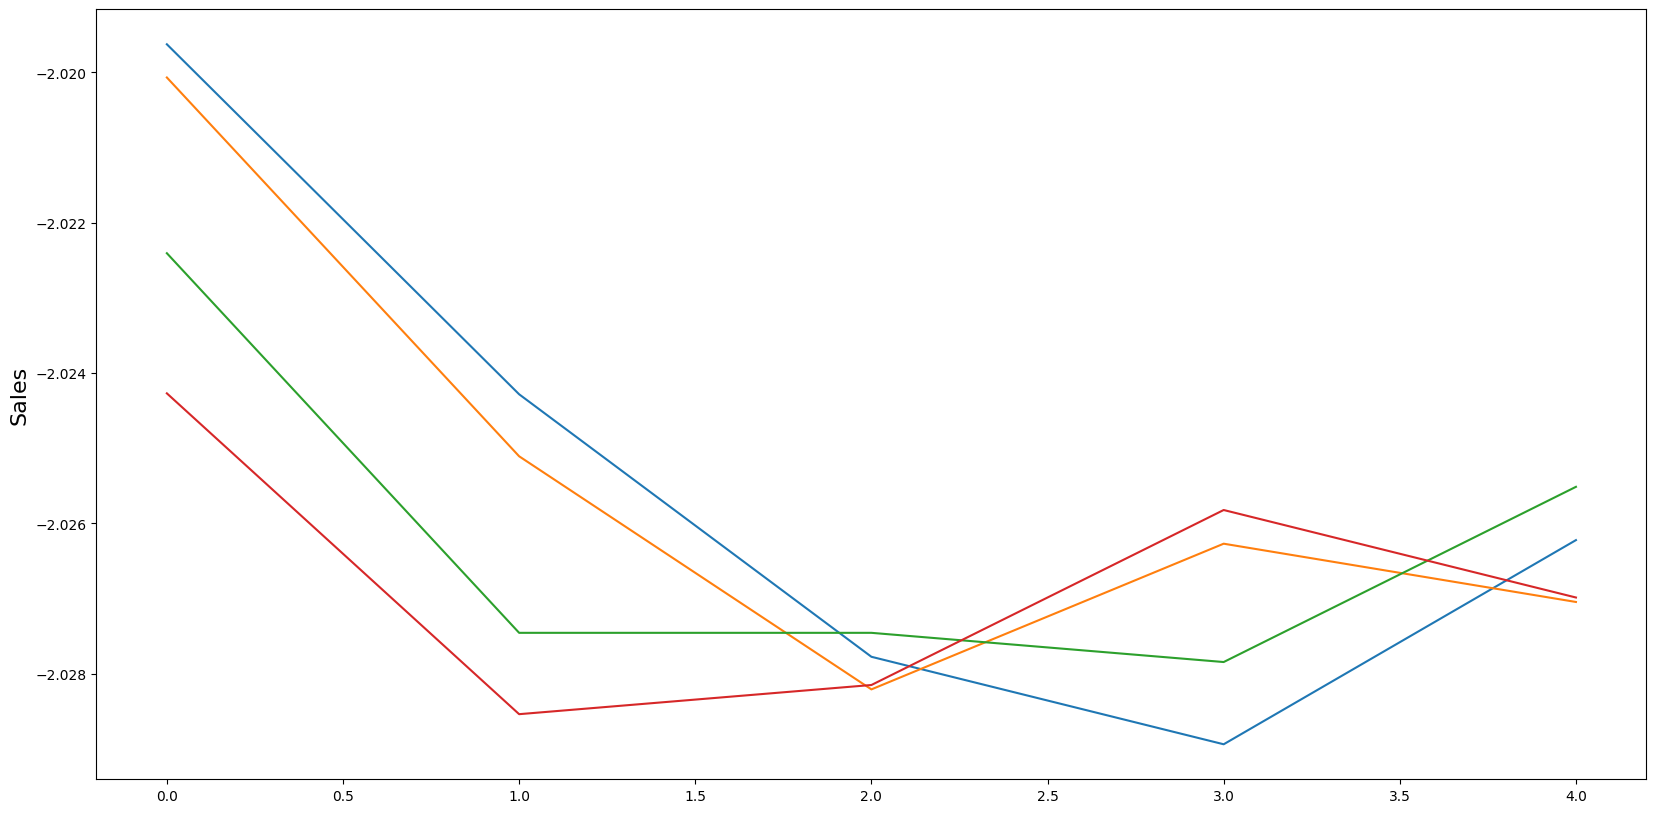

In [23]:
plt.figure(figsize=(20,10))
plt.plot(df_scaled.head())
#plt.title('Log of HSI', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [24]:
df.head()

,open,high,low,close
Time,,,,
21/10/2002 01:15:00,0.97320,0.97340,0.97260,0.97260
21/10/2002 01:30:00,0.97260,0.97275,0.97195,0.97205
21/10/2002 01:45:00,0.97215,0.97235,0.97195,0.97210
21/10/2002 02:00:00,0.97200,0.97260,0.97190,0.97240
21/10/2002 02:15:00,0.97235,0.97250,0.97220,0.97225


In [25]:
trainX = []
trainY = []

n_future = 1
n_past = 15

for i in range(n_past, len(df_scaled) - n_future + 1):
    trainX.append(df_scaled.iloc[i - n_past:i, 0:df_scaled.shape[1]].values)
    trainY.append(df_scaled.iloc[i + n_future - 1:i + n_future, 0].values)

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (533030, 30, 4).
trainY shape == (533030, 1).


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            17664     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30113 (117.63 KB)
Trainable params: 30113 (117.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
29982/29982 [==============================] - 1676s 56ms/step - loss: 0.0246 - val_loss: 0.0026
Epoch 2/5
29982/29982 [====================

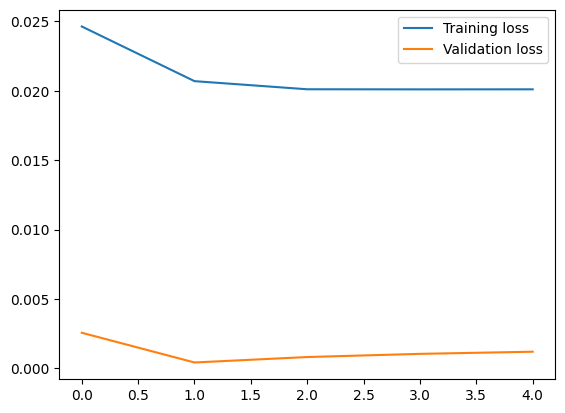

In [12]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [13]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

#predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
#print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]



# Convert timestamp to daty
y_pred_future

1/1 [==============================] - 0s 393ms/step


array([1.0609543, 1.0606283, 1.0611144, 1.0606774, 1.0609101, 1.0610812,
       1.0608228, 1.061352 , 1.0610352, 1.0613129, 1.0612761, 1.0612257,
       1.0612581, 1.0612602, 1.0612048], dtype=float32)

In [14]:
trainX

array([[[-2.0196251 , -2.02006704, -2.02240581, -2.02427071],
        [-2.02428311, -2.02510828, -2.02745792, -2.02854046],
        [-2.02777662, -2.02821059, -2.02745792, -2.0281523 ],
        ...,
        [-2.01574342, -2.01696474, -2.01541059, -2.01728385],
        [-2.01807243, -2.01967925, -2.01735371, -2.01767201],
        [-2.0184606 , -2.01890368, -2.01696508, -2.01883649]],

       [[-2.02428311, -2.02510828, -2.02745792, -2.02854046],
        [-2.02777662, -2.02821059, -2.02745792, -2.0281523 ],
        [-2.02894112, -2.02627165, -2.02784654, -2.02582335],
        ...,
        [-2.01807243, -2.01967925, -2.01735371, -2.01767201],
        [-2.0184606 , -2.01890368, -2.01696508, -2.01883649],
        [-2.01807243, -2.0181281 , -2.01618784, -2.01728385]],

       [[-2.02777662, -2.02821059, -2.02745792, -2.0281523 ],
        [-2.02894112, -2.02627165, -2.02784654, -2.02582335],
        [-2.02622395, -2.02704722, -2.0255148 , -2.02698782],
        ...,
        [-2.0184606 , -2.01